In [1]:
import torch
import torch.nn as nn
import numpy as np
import pylab as plt

import math
from torch.distributions import MultivariateNormal

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


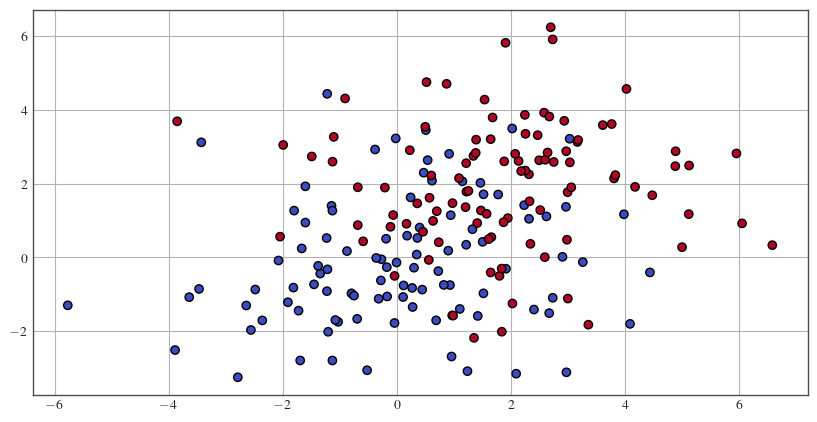

In [2]:

torch.manual_seed(1)
noise = 3
gt_params = [
    {'mean': torch.Tensor([0, 0]), 'cov': torch.eye(2)*noise, 'label': 0},
    # {'mean': torch.Tensor([0, 0]), 'cov': torch.eye(2)*noise, 'label': 0},
    # {'mean': torch.Tensor([0, 0]), 'cov': torch.eye(2)*noise, 'label': 0},
    # {'mean': torch.Tensor([0, 0]), 'cov': torch.eye(2)*noise, 'label': 0},
    {'mean': torch.Tensor([2, 2]), 'cov': torch.eye(2)*noise, 'label': 1},
    # {'mean': torch.Tensor([-2, -2]), 'cov': torch.eye(2)*noise, 'label': 1},
    # {'mean': torch.Tensor([-2, 2]), 'cov': torch.eye(2)*noise, 'label': 1},
    # {'mean': torch.Tensor([2, -2]), 'cov': torch.eye(2)*noise, 'label': 1},
    # {'mean': torch.Tensor([6, 6]), 'cov': torch.eye(2), 'label': 0},
]
gt_dists = {i: MultivariateNormal(params['mean'], params['cov'])  for i, params in enumerate(gt_params)}
n_samples_per_comp = 100

X = torch.cat([dist.sample((n_samples_per_comp,)) for i, dist in gt_dists.items()])
y = torch.cat([torch.full((n_samples_per_comp,), fill_value=params['label']) for params in gt_params])

dataset = torch.utils.data.TensorDataset(X, y)

X_test = torch.cat([dist.sample((n_samples_per_comp,)) for i, dist in gt_dists.items()])
y_test = torch.cat([torch.full((n_samples_per_comp,), fill_value=params['label']) for params in gt_params])

axis = torch.linspace(-9, 9, 101)
xx, yy = torch.meshgrid(axis, axis)
zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)


plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


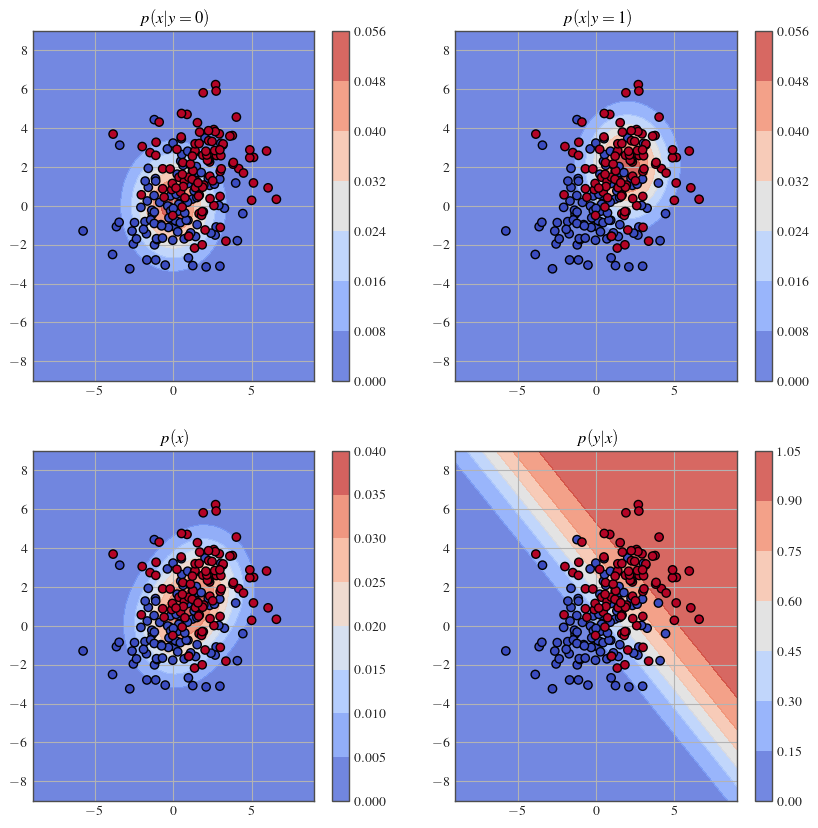

In [3]:
# Definition of ground truth probabilities based on the data generating distributions
def log_prior(x):
    dist_indices = [i for i, params in enumerate(gt_params) if params['label'] == x]
    return math.log(n_samples_per_comp*len(dist_indices)) - math.log(len(y))

def log_likelihood(x, y):
    dist_indices = [i for i, params in enumerate(gt_params) if params['label'] == y]
    log_probs = torch.Tensor([gt_dists[idx].log_prob(x) for idx in dist_indices])
    log_priors = torch.Tensor([n_samples_per_comp/(n_samples_per_comp*len(dist_indices)) for _ in log_probs]).log()
    log_likelihood = torch.logsumexp(log_priors + log_probs, dim=0)
    return log_likelihood

def log_marginal(x):
    n_classes = 2
    log_likelihoods = torch.Tensor([log_likelihood(x, i) for i in range(n_classes)])
    log_priors = torch.Tensor([log_prior(i) for i in range(n_classes)])
    return torch.logsumexp(log_priors+log_likelihoods, dim=0)

def log_posterior(y, x):
    return log_likelihood(x, y) + log_prior(y) - log_marginal(x)


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title('$p(x|y=0)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
likelihoods = torch.Tensor([log_likelihood(x, 0).exp() for x in zz])
plt.contourf(xx, yy, likelihoods.view(xx.shape), alpha=.8, zorder=0)
plt.colorbar()

plt.subplot(222)
plt.title('$p(x|y=1)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
likelihoods = torch.Tensor([log_likelihood(x, 1).exp() for x in zz])
plt.contourf(xx, yy, likelihoods.view(xx.shape), alpha=.8, zorder=0)
plt.colorbar()

plt.subplot(223)
plt.title('$p(x)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
marginal_density = torch.Tensor([log_marginal(x).exp() for x in zz])
plt.contourf(xx, yy, marginal_density.view(xx.shape), alpha=.8, zorder=0)
plt.colorbar()

plt.subplot(224)
plt.title('$p(y|x)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
gt_probas = torch.Tensor([log_posterior(1, x).exp() for x in zz])
plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0)
plt.colorbar()
plt.show()

## Supervised Training

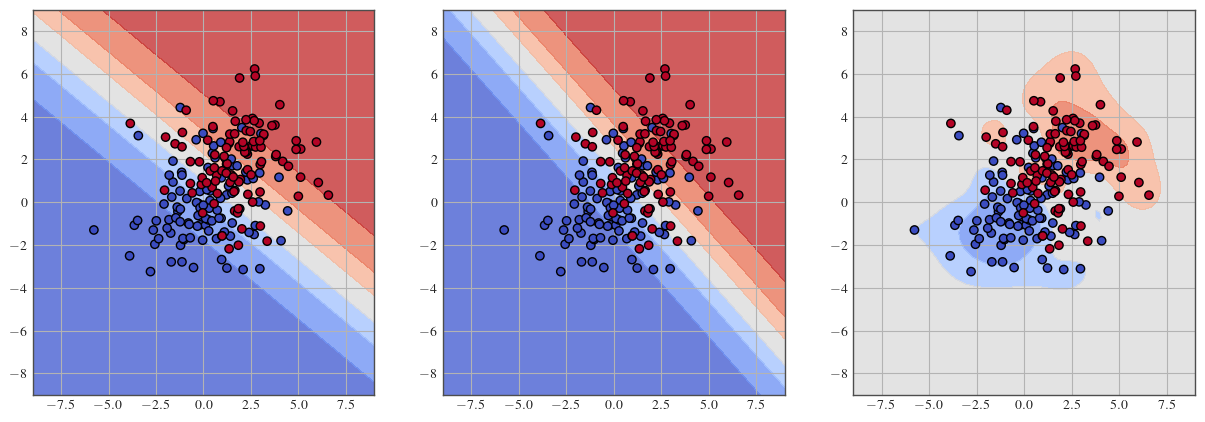

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier

levels = [0, .1, .25, .4, .6, .75, .9, 1]

plt.figure(figsize=(15, 5))
plt.subplot(131)
model = LogisticRegression()
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y)
with torch.no_grad():
    probas = model.predict_proba(zz)[:, 1]
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=.8, zorder=0, levels=levels)

plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)

plt.subplot(133)
model = GaussianProcessClassifier()
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y)
gt_probas_epistemic = model.predict_proba(zz)[:, 1]
plt.contourf(xx, yy, gt_probas_epistemic.reshape(xx.shape), alpha=.8, zorder=0, levels=levels)

plt.show()

## Active Learning - Random Sampling

Using train_dataset for queries. Make sure that there are no augmentations used.


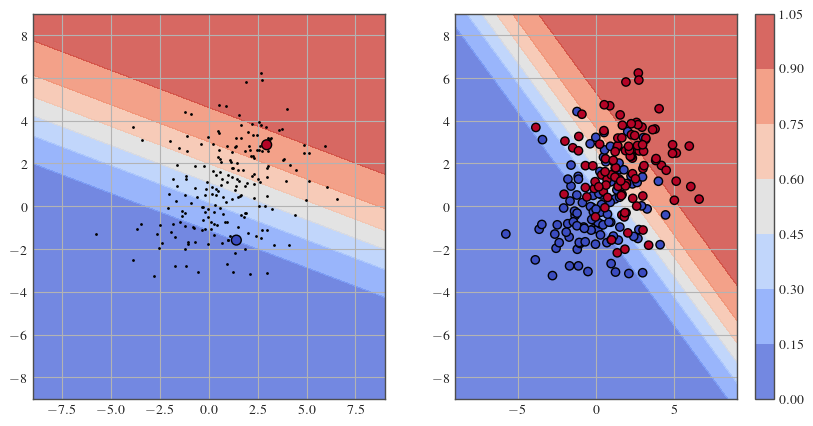

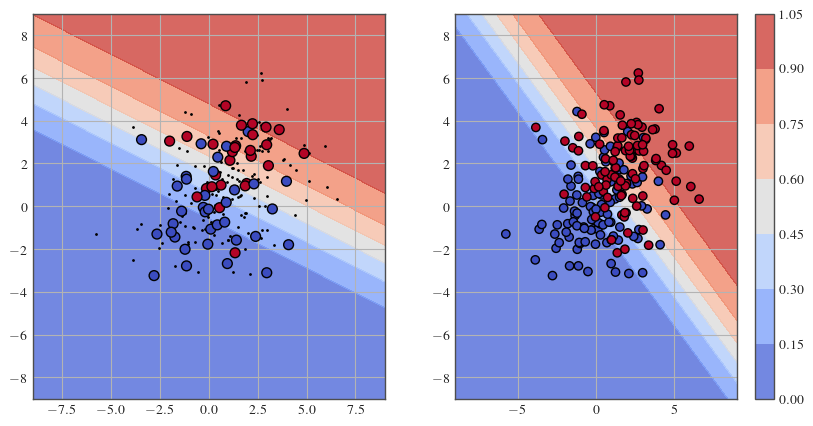

In [5]:
from dal_toolbox.active_learning.strategies import random
from dal_toolbox.active_learning.data import ALDataset

hparams = dict(n_init=2, n_cycles=1, acq_size=60, seed=0)

torch.manual_seed(hparams['seed'])

# AL Setup
al_dataset_random = ALDataset(dataset, random_state=hparams['seed'])
al_dataset_random.random_init(hparams['n_init'], class_balanced=True)
al_strat = random.RandomSampling()

results = []

for i_cycle in range(hparams['n_cycles']+1):
    if i_cycle != 0:
        indices = al_strat.query(
            unlabeled_indices=al_dataset_random.unlabeled_indices,
            acq_size=hparams['acq_size']
        )
        al_dataset_random.update_annotations(indices)

    model_random = LogisticRegression() 
    model_random.fit(X[al_dataset_random.labeled_indices], y[al_dataset_random.labeled_indices])

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(X[al_dataset_random.unlabeled_indices, 0], X[al_dataset_random.unlabeled_indices, 1], c='k', s=1)
    plt.scatter(X[al_dataset_random.labeled_indices, 0], X[al_dataset_random.labeled_indices, 1], c=y[al_dataset_random.labeled_indices], s=50)

    probas = torch.from_numpy(model_random.predict_proba(zz)[:, 1])
    plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0)
    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0)
    plt.colorbar()
    plt.show()

## Active Learning - Uncertainty Sampling

Using train_dataset for queries. Make sure that there are no augmentations used.


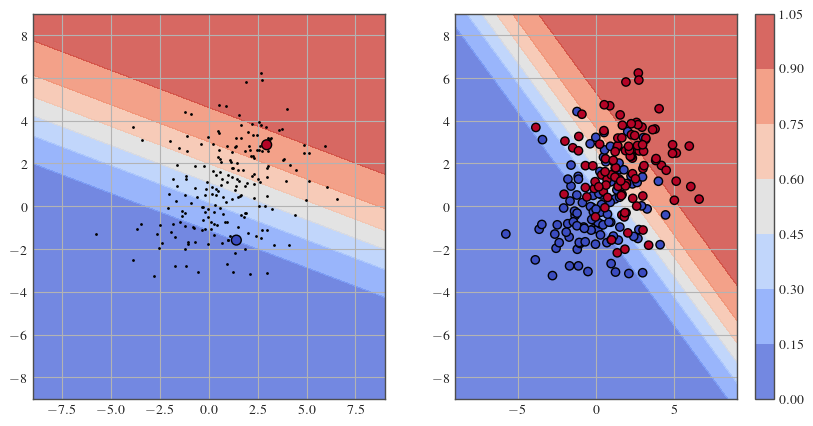

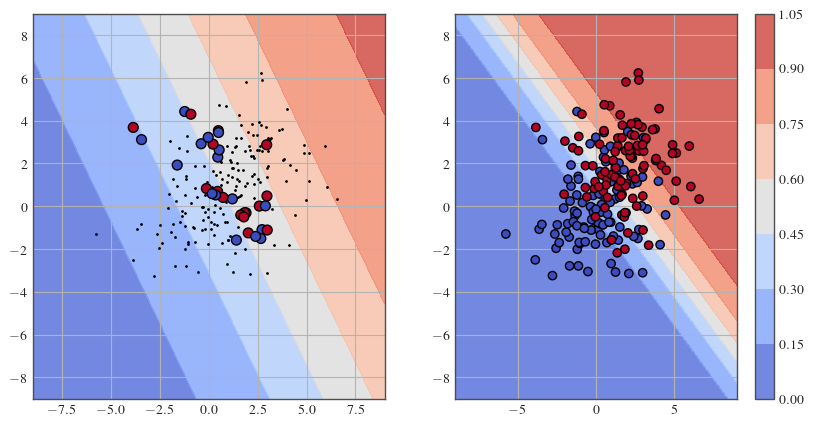

In [6]:
from dal_toolbox.active_learning.strategies import uncertainty
from dal_toolbox.active_learning.data import ALDataset

hparams = dict(n_init=2, n_cycles=30, acq_size=2, seed=0)

torch.manual_seed(hparams['seed'])

# AL Setup
al_dataset_uncertainty = ALDataset(dataset, random_state=hparams['seed'])
al_dataset_uncertainty.random_init(hparams['n_init'], class_balanced=True)

results = []

for i_cycle in range(hparams['n_cycles']+1):
    if i_cycle != 0:
        # Entropy strat
        probas = model.predict_proba(X[al_dataset_uncertainty.unlabeled_indices])
        scores = - np.sum(probas * np.log(probas), -1)
        idx = scores.argmax()
        al_dataset_uncertainty.update_annotations([al_dataset_uncertainty.unlabeled_indices[idx]])

    model_uncertainty = LogisticRegression()
    model_uncertainty.fit(X[al_dataset_uncertainty.labeled_indices], y[al_dataset_uncertainty.labeled_indices])

    if i_cycle == 0 or i_cycle == hparams['n_cycles']:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.scatter(X[al_dataset_uncertainty.unlabeled_indices, 0], X[al_dataset_uncertainty.unlabeled_indices, 1], c='k', s=1)
        plt.scatter(X[al_dataset_uncertainty.labeled_indices, 0], X[al_dataset_uncertainty.labeled_indices, 1], c=y[al_dataset_uncertainty.labeled_indices], s=50)
        probas = torch.from_numpy(model_uncertainty.predict_proba(zz)[:, 1])
        plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0)
        plt.subplot(122)
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0)
        plt.colorbar()
        plt.show()



## Active Learning - Optimal Aleatoric Selection

Using train_dataset for queries. Make sure that there are no augmentations used.


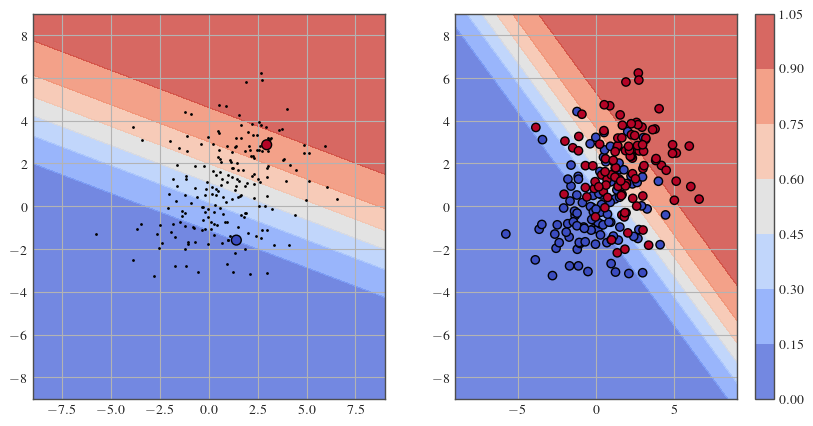

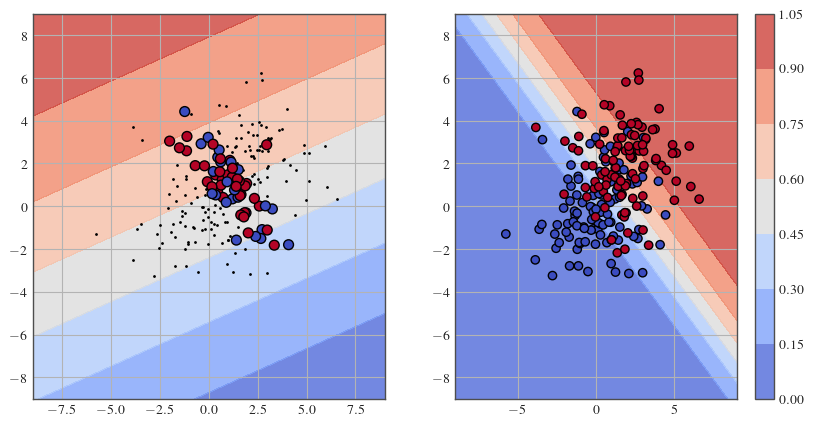

In [7]:
from dal_toolbox.active_learning.strategies import uncertainty
from dal_toolbox.active_learning.data import ALDataset
torch.manual_seed(0)

hparams = dict(n_init=2, n_cycles=1, acq_size=60, seed=0)

torch.manual_seed(hparams['seed'])
# AL Setup
al_dataset_opt_aleatoric_entropy = ALDataset(dataset, random_state=hparams['seed'])
al_dataset_opt_aleatoric_entropy.random_init(hparams['n_init'], class_balanced=True)
uncertainty_sampling = uncertainty.UncertaintySampling(batch_size=256)

results = []

for i_cycle in range(hparams['n_cycles']+1):
    if i_cycle != 0:
        probas = torch.Tensor([log_posterior(1, x) for x in X[al_dataset_opt_aleatoric_entropy.unlabeled_indices]]).exp()
        probas = torch.stack([1-probas, probas], dim=1)
        scores = - torch.sum(probas * torch.log(probas+1e-9), dim=-1)
        indices = np.argsort(scores)[-hparams['acq_size']:]
        actual_indices = [al_dataset_opt_aleatoric_entropy.unlabeled_indices[idx] for idx in indices]
        al_dataset_opt_aleatoric_entropy.update_annotations(actual_indices)

    model_opt_aleatoric_entropy = LogisticRegression()
    model_opt_aleatoric_entropy.fit(X[al_dataset_opt_aleatoric_entropy.labeled_indices], y[al_dataset_opt_aleatoric_entropy.labeled_indices])

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.scatter(X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 1], c='k', s=1)
    plt.scatter(X[al_dataset_opt_aleatoric_entropy.labeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.labeled_indices, 1], c=y[al_dataset_opt_aleatoric_entropy.labeled_indices], s=50)
    probas = torch.from_numpy(model_opt_aleatoric_entropy.predict_proba(zz)[:, 1])
    plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0)
    plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0)
    plt.colorbar()
    plt.show()

## Active Learning - Optimal Epistemic

Using train_dataset for queries. Make sure that there are no augmentations used.


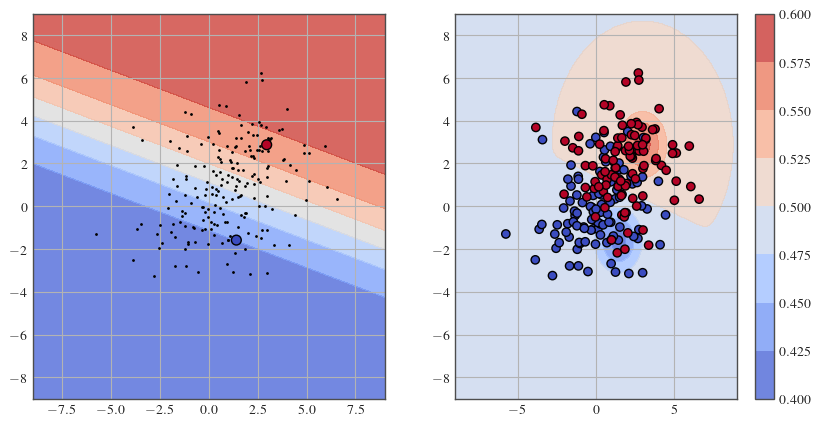

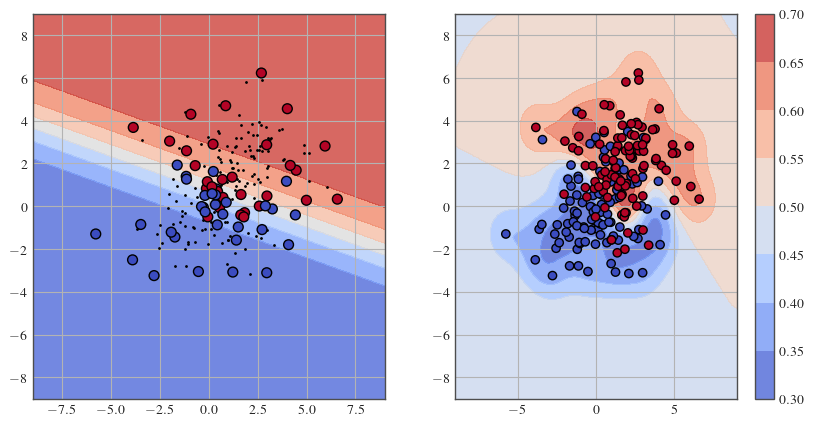

In [8]:
from dal_toolbox.active_learning.strategies import uncertainty
from dal_toolbox.active_learning.data import ALDataset

hparams = dict(n_init=2, n_cycles=30, acq_size=2, seed=0)

torch.manual_seed(hparams['seed'])
# AL Setup
al_dataset_opt_epistemic_entropy = ALDataset(dataset, random_state=hparams['seed'])
al_dataset_opt_epistemic_entropy.random_init(hparams['n_init'], class_balanced=True)

results = []

for i_cycle in range(hparams['n_cycles']+1):
    if i_cycle != 0:
        gt_model_epistemic = GaussianProcessClassifier()
        gt_model_epistemic.fit(X[al_dataset_opt_epistemic_entropy.labeled_indices], y[al_dataset_opt_epistemic_entropy.labeled_indices])
        probas = gt_model_epistemic.predict_proba(X[al_dataset_opt_epistemic_entropy.unlabeled_indices])
        probas = torch.from_numpy(probas)
        scores = - torch.sum(probas * torch.log(probas+1e-9), dim=-1)
        indices = np.argsort(scores)[-hparams['acq_size']:]
        actual_indices = [al_dataset_opt_epistemic_entropy.unlabeled_indices[idx] for idx in indices]
        al_dataset_opt_epistemic_entropy.update_annotations(actual_indices)

    model_opt_epistemic_entropy = LogisticRegression()
    model_opt_epistemic_entropy.fit(X[al_dataset_opt_epistemic_entropy.labeled_indices], y[al_dataset_opt_epistemic_entropy.labeled_indices])

    gt_model_epistemic = GaussianProcessClassifier()
    gt_model_epistemic.fit(X[al_dataset_opt_epistemic_entropy.labeled_indices], y[al_dataset_opt_epistemic_entropy.labeled_indices])
    gt_probas = gt_model_epistemic.predict_proba(zz)[:, 1]

    if i_cycle == 0 or i_cycle == hparams['n_cycles']:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.scatter(X[al_dataset_opt_epistemic_entropy.unlabeled_indices, 0], X[al_dataset_opt_epistemic_entropy.unlabeled_indices, 1], c='k', s=1)
        plt.scatter(X[al_dataset_opt_epistemic_entropy.labeled_indices, 0], X[al_dataset_opt_epistemic_entropy.labeled_indices, 1], c=y[al_dataset_opt_epistemic_entropy.labeled_indices], s=50)
        probas = torch.from_numpy(model_opt_epistemic_entropy.predict_proba(zz)[:, 1])
        plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0)
        plt.subplot(122)
        plt.scatter(X[:, 0], X[:, 1], c=y)
        plt.contourf(xx, yy, gt_probas.reshape(xx.shape), alpha=.8, zorder=0)
        plt.colorbar()
        plt.show()

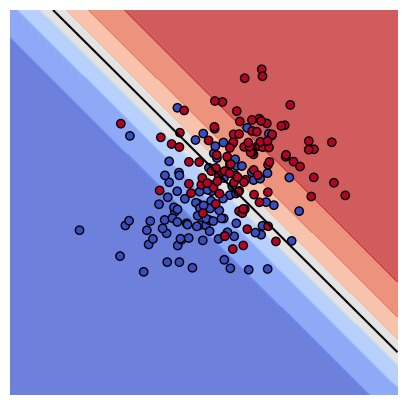

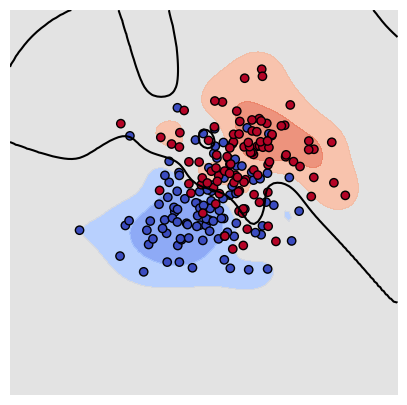

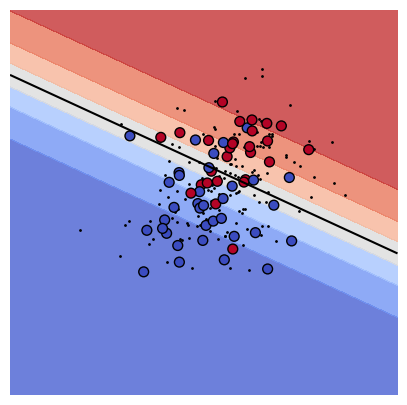

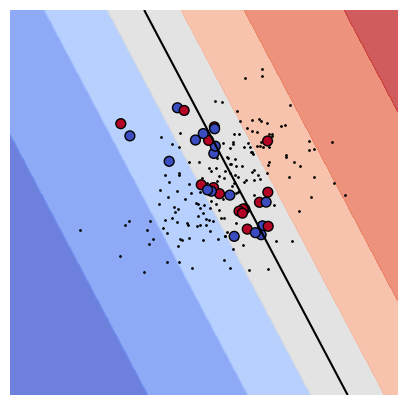

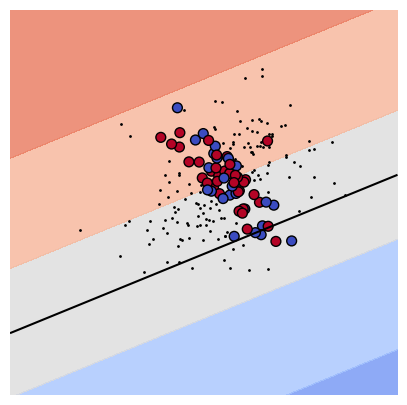

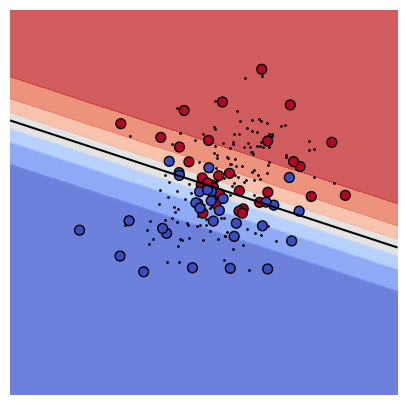

In [9]:
levels = [0, .1, .25, .4, .6, .75, .9, 1]

fig = plt.figure(figsize=(5, 5))
# plt.title('$p(y|x)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
gt_probas = torch.Tensor([log_posterior(1, x).exp() for x in zz])
contourf = plt.contourf(xx, yy, gt_probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, gt_probas.view(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_2d/synthetic_2d_gt_aleatoric.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

fig = plt.figure(figsize=(5, 5))
# plt.title('$p(y|x)$')
plt.scatter(X[:, 0], X[:, 1], c=y)
contourf = plt.contourf(xx, yy, gt_probas_epistemic.reshape(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, gt_probas_epistemic.reshape(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_2d/synthetic_2d_gt_epistemic.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.scatter(X[al_dataset_random.unlabeled_indices, 0], X[al_dataset_random.unlabeled_indices, 1], c='k', s=1)
plt.scatter(X[al_dataset_random.labeled_indices, 0], X[al_dataset_random.labeled_indices, 1], c=y[al_dataset_random.labeled_indices], s=50)
probas = torch.from_numpy(model_random.predict_proba(zz)[:, 1])
plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, probas.view(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_2d/synthetic_2d_random.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.scatter(X[al_dataset_uncertainty.unlabeled_indices, 0], X[al_dataset_uncertainty.unlabeled_indices, 1], c='k', s=1)
plt.scatter(X[al_dataset_uncertainty.labeled_indices, 0], X[al_dataset_uncertainty.labeled_indices, 1], c=y[al_dataset_uncertainty.labeled_indices], s=50)
probas = torch.from_numpy(model_uncertainty.predict_proba(zz)[:, 1])
plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, probas.view(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_2d/synthetic_2d_uncertainty.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.scatter(X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 1], c='k', s=1)
plt.scatter(X[al_dataset_opt_aleatoric_entropy.labeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.labeled_indices, 1], c=y[al_dataset_opt_aleatoric_entropy.labeled_indices], s=50)
probas = torch.from_numpy(model_opt_aleatoric_entropy.predict_proba(zz)[:, 1])
plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, probas.view(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.axis('off')
plt.grid()

plt.savefig('./synthetic_2d/synthetic_2d_optimal_aleatoric.pdf', bbox_inches='tight', pad_inches=0)

fig = plt.figure(figsize=(5, 5))
plt.scatter(X[al_dataset_opt_epistemic_entropy.unlabeled_indices, 0], X[al_dataset_opt_epistemic_entropy.unlabeled_indices, 1], c='k', s=1)
plt.scatter(X[al_dataset_opt_epistemic_entropy.labeled_indices, 0], X[al_dataset_opt_epistemic_entropy.labeled_indices, 1], c=y[al_dataset_opt_epistemic_entropy.labeled_indices], s=50)
probas = torch.from_numpy(model_opt_epistemic_entropy.predict_proba(zz)[:, 1])
plt.contourf(xx, yy, probas.view(xx.shape), alpha=.8, zorder=0, levels=levels)
plt.contour(xx, yy, probas.view(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
plt.axis('off')
plt.grid()

plt.savefig('./synthetic_2d/synthetic_2d_optimal_epistemic.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

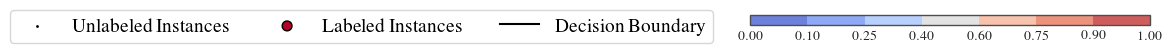

In [10]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.unlabeled_indices, 1], c='k', s=1, label='Unlabeled Instances')
plt.scatter(X[al_dataset_opt_aleatoric_entropy.labeled_indices, 0], X[al_dataset_opt_aleatoric_entropy.labeled_indices, 1], c=y[al_dataset_opt_aleatoric_entropy.labeled_indices], s=50, label='Labeled Instances')
probas = model_opt_epistemic_entropy.predict_proba(zz)[:, 1]
plt.contourf(xx, yy, probas.reshape(xx.shape), alpha=.8, zorder=0, levels=levels)
contour = plt.contour(xx, yy, probas.reshape(xx.shape), alpha=1, zorder=1, levels=[0.5], colors='black')
# contour.collections[0].set_label('Decision Boundary')
plt.grid()
plt.plot([0, 0], [0, 0], color='black', label='Decision Boundary')
plt.gca().set_visible(False)

fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=5, prop=dict(size=14))
cax = plt.axes([1.5, 1.05, .8, .02])
plt.colorbar(contourf, cax=cax, orientation='horizontal')
plt.savefig('synthetic_2d_legend.pdf', bbox_inches='tight', pad_inches=0) 
